In [1]:
# If on cluster, cwd is '/rds/general/user/nz423', not the project directory, breaking imports
import os
import sys
from pathlib import Path

project_dir = Path(os.getcwd()) / "exploring-hydra-boosting"
if "rds" not in project_dir.parts:
    project_dir = project_dir.parent
    datasets_dir = project_dir.parent.parent / "Data"
else:
    datasets_dir = project_dir / "DATASETS"
    if str(project_dir) not in sys.path:
        sys.path.append(str(project_dir))
    
class Config:
    project_dir = project_dir
    TSER_dir = datasets_dir / "TSER"
    BigTSC_dir = datasets_dir / "BigTSC"
    UTSC_dir = datasets_dir / "UTSC"
    results_dir = project_dir / "results"

print(Config.project_dir)
print(Config.TSER_dir)
print(Config.BigTSC_dir)
print(Config.UTSC_dir)
print(Config.results_dir)

/rds/general/user/nz423/home/exploring-hydra-boosting
/rds/general/user/nz423/home/exploring-hydra-boosting/DATASETS/TSER
/rds/general/user/nz423/home/exploring-hydra-boosting/DATASETS/BigTSC
/rds/general/user/nz423/home/exploring-hydra-boosting/DATASETS/UTSC
/rds/general/user/nz423/home/exploring-hydra-boosting/results


In [2]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import os
import sys
import pathlib
from pathlib import Path


import numpy as np
import aeon
import torch
from torch import Tensor
import torch.nn as nn
import torch.functional as F
import pandas as pd
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))
from aeon.datasets import load_regression
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from tqdm import tqdm
from tsml_eval.evaluation.storage import load_regressor_results
from tsml_eval.experiments import (
    experiments,
    get_regressor_by_name,
    run_regression_experiment,
)
from aeon.visualisation import plot_critical_difference
from aeon.benchmarking.results_loaders import get_estimator_results

np.set_printoptions(precision=3, threshold=5) # Print options

/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


# Aeon Regressor testing

In [3]:
# # set_regressor can be used to find various regressors by string, but
# # any aeon, tsml or sklearn regressor can be used in the experiments function
# regressor = get_regressor_by_name("multirockethydra")

# # record memory usage every 0.1 seconds, just here for notebook speed
# # does not need to be changed for usage
# experiments.MEMRECORD_INTERVAL = 0.1

# run_regression_experiment(
#     X_train,
#     y_train,
#     X_test,
#     y_test,
#     regressor,
#     Config.project_dir / "results",
#     dataset_name=dataset_name,
#     resample_id=0,
# )

# rr = load_regressor_results(
#     Config.project_dir / "results" / "MultiRocketHydraRegressor" / "Predictions" / dataset_name / "testResample0.csv"
# )
# print(rr.predictions)
# print(rr.mean_squared_error, "mse")
# print(rr.root_mean_squared_error, "rmse")
# print(rr.mean_absolute_percentage_error, "mape")
# print(rr.r2_score, "r2")

# benchmark against other

In [3]:
from run_regression_experiments import TSER_datasets

#TSER_datasets = TSER_datasets[10:11]
# datasets = [
#     "CardanoSentiment",
#     "Covid3Month",
#     "FloodModeling1",
#     "FloodModeling2",
#     "NaturalGasPricesSentiment",
#     #"MethaneMonitoringHomeActivity",
#     "HouseholdPowerConsumption1",
#     #"AustraliaRainfall"
# ]





def add_regressor_to_benchmarks(
    model_name: str,
    datasets: List[str],
    results_dir: Path,
    benchmarks: Dict,
    ):
    results = {}
    for dataset_name in datasets:
        rr = load_regressor_results(
            results_dir / model_name / "Predictions" / dataset_name / f"testResample{0}.csv"
        )
        results[dataset_name] = rr.root_mean_squared_error
    benchmarks[model_name] = results
    return results



def benchmark_models(
    datasets: List[str] = TSER_datasets,
    project_dir: Path = Config.project_dir,
    results_dir: Path = Config.results_dir,
    new_models: List[str] = ["NaiveMean"],
    aeon_models: List[str] = ["InceptionT", "FreshPRINCE", "DrCIF", "Rocket", "RandF", "RotF", "XGBoost", "Ridge"],
    benchmarks: Optional[Dict] = None
):
    # get aeon benchmarks
    if benchmarks is None:
        benchmarks = get_estimator_results(
            datasets=datasets, estimators=aeon_models, task="regression", measure="rmse", 
            path = project_dir / "data" / "bench_regression_TSER",
            default_only = True # default train/test (True) or 30 resamples (False) #TODO only suppporting default split atm
        )
    
    # add my own models
    for model_name in new_models:
        add_regressor_to_benchmarks(
            model_name,
            datasets,
            results_dir,
            benchmarks
        )
    return benchmarks

/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
benchmarks = benchmark_models(
    TSER_datasets[:],
    results_dir = Config.project_dir / "results",
    new_models = ["NaiveMean", "HydraFeatureBoost_OH", "HydraLabelBoost_OH", "HydraLabelReuseBoost_OH", "Hydra_OH", "HydraEnsemble_OH"],
)
table = pd.DataFrame(benchmarks)
table

/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/

,InceptionT,FreshPRINCE,DrCIF,Rocket,RandF,RotF,XGBoost,Ridge,NaiveMean,HydraFeatureBoost_OH,HydraLabelBoost_OH,HydraLabelReuseBoost_OH,Hydra_OH,HydraEnsemble_OH
BIDMC32HR,7.222708,10.616631,8.006972,6.813961,14.996338,4.947497,13.864843,14.868206,14.110200,8.506937,7.845947,8.360451,7.360176,7.143696
BIDMC32SpO2,5.784348,5.102724,4.855296,4.652436,4.549775,1.659771,4.436033,4.963935,4.802912,4.992835,5.130344,4.981038,5.147352,5.257189
PPGDalia,11.075060,15.241872,15.085781,14.096621,17.434028,14.764772,15.321998,20.754549,22.643591,13.209616,13.373890,13.549579,13.428570,13.029167
BIDMC32RR,3.221975,4.039938,4.301645,4.100524,4.345821,1.720790,4.314306,3.340824,3.496753,4.510900,4.411714,5.480420,4.608996,4.555595
NewsTitleSentiment,0.139854,0.142208,0.142239,0.143013,0.142700,0.145367,0.139338,0.139213,0.138105,0.138057,0.138057,0.138059,0.138057,0.138058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BitcoinSentiment,0.242200,0.226563,0.219815,0.295793,0.231098,0.195272,0.228481,0.260587,0.273654,0.229946,0.230923,0.230003,0.229718,0.230836
BinanceCoinSentiment,0.381258,0.339670,0.338732,0.387779,0.346741,0.347920,0.354200,0.397304,0.363010,0.354539,0.335480,0.331277,0.346530,0.347182
DailyOilGasPrices,1.542210,1.172234,1.046399,1.922385,1.208112,1.511486,1.390036,1.713667,1.800964,1.455653,1.400190,1.350705,1.350088,1.466732
CardanoSentiment,0.379025,0.289479,0.313388,0.298396,0.300677,0.322384,0.355953,0.389053,0.300261,0.317547,0.329490,0.334623,0.317343,0.301318


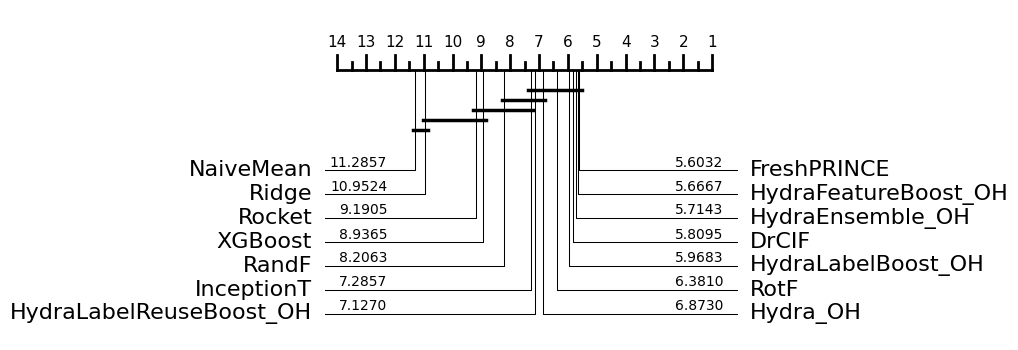

In [7]:
plt, _ = plot_critical_difference(
    np.array(table), list(table.columns), lower_better=True
)
plt.show()

# Classifier

In [7]:
# TODO whats the proper way to load the TSC results? same library?

# Distribution of parameters

In [8]:
import matplotlib.pyplot as plt

# def plot_distribution(
#     parameters=["l2_ghat", "l2_reg", "n_layers"],
#     model_name="HydraBoostGridSearchHoldout",
#     results_dir: Path = Config.results_dir,
# ):
#     #step 1: loop over all csv files in results_dir / "Predictions"
    
#     #step 2: in each csv file, the second line will be the parameter dict, for example {'seed': 0, 'boost_lr': 0.5, 'hydra_batch_size': 10000, 'init_n_groups': 64, 'init_n_kernels': 8, 'l2_ghat': 0.01, 'l2_reg': 0.01, 'max_num_channels': 3, 'n_groups': 64, 'n_kernels': 8, 'n_layers': 1}
    
#     #step 3: retrieve all values from the dict with keys in 'parameters' arg.
    
#     #step 4: plot histograms, side by side one with ordinary x scale, one with log x scale. take log 1+x too.
#     # steal this from previous repo.


def plot_distribution(
    parameters=["l2_ghat", "l2_reg", "n_layers", "boost_lr"],
    model_name="HydraFeatureBoost_OH",
    results_dir: Path = Config.results_dir,
):
    # Step 1: Get all CSV files for the specified model
    pred_dir = results_dir / model_name / "Predictions"
    csv_files = []
    for dataset_dir in pred_dir.glob("*"):
        if dataset_dir.is_dir():
            csv_files.extend(dataset_dir.glob("testResample*.csv"))
    
    # Step 2: Read parameter values from CSV files
    param_values = {param: [] for param in parameters} # Initialize dictionary to store parameter values
    for csv_file in csv_files:
        with open(csv_file, 'r') as f:
            next(f) # Skip first line (header)
            param_dict = eval(next(f).strip()) # Read parameter dict from second line
            for param in parameters:
                if param in param_dict:
                    param_values[param].append(param_dict[param])
                    
    # Step 3: Create plots
    n_params = len(parameters)
    fig, axes = plt.subplots(n_params, 2, figsize=(12, 4*n_params))
    
    for i, param in enumerate(parameters):
        values = param_values[param]
        if param=="n_layers" or param =="n_estimators":
            values = np.array(values) + 1
        
        # Linear scale histogram
        axes[i, 0].hist(values, bins=30)
        axes[i, 0].set_xlabel(param)
        axes[i, 0].set_ylabel('Count')
        axes[i, 0].set_title(f'{param} (Linear Scale)')
        
        # Log scale histogram
        log_values = np.log10(values)
        axes[i, 1].hist(log_values, bins=30)
        axes[i, 1].set_xlabel(f'log({param})')
        axes[i, 1].set_ylabel('Count')
        axes[i, 1].set_title(f'{param} (Log Scale)')
    
    plt.tight_layout()
    return fig


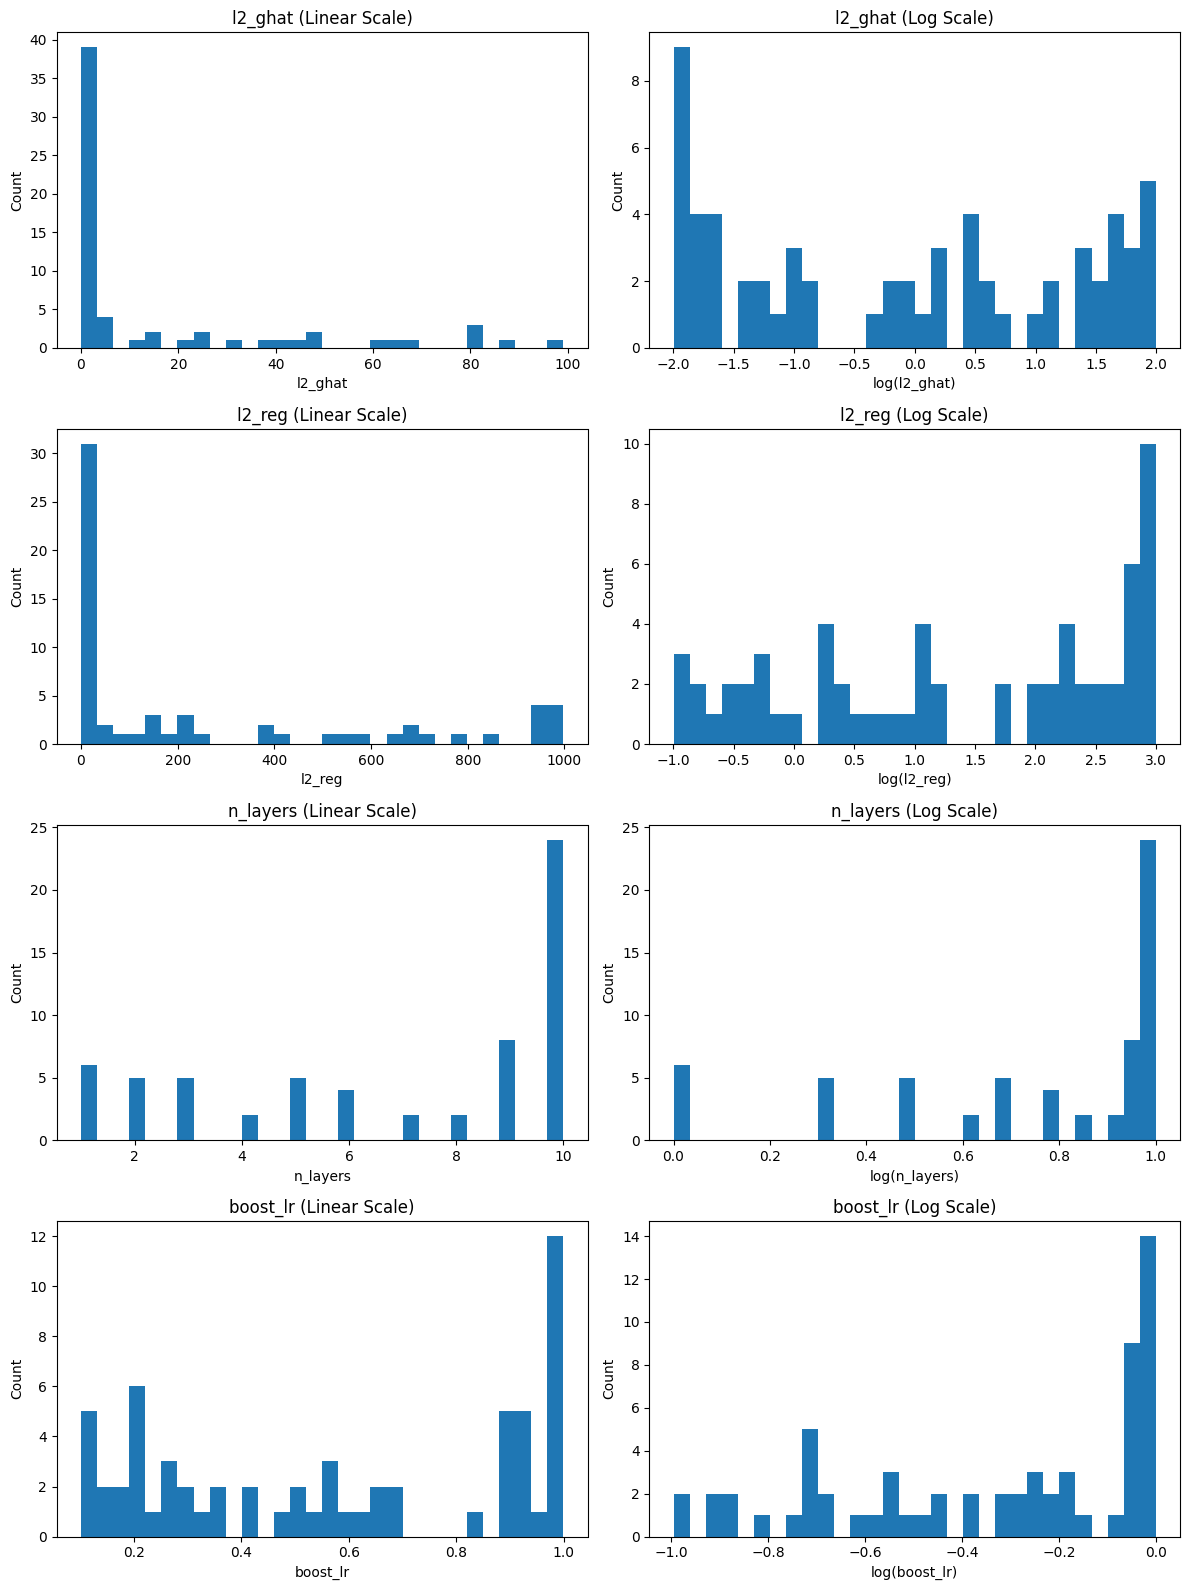

In [9]:

# Example usage:
fig = plot_distribution(
    parameters = ["l2_ghat", "l2_reg", "n_layers", "boost_lr"],
    model_name = "HydraFeatureBoost_OH",
    results_dir = Config.project_dir / "results",
)
plt.show()

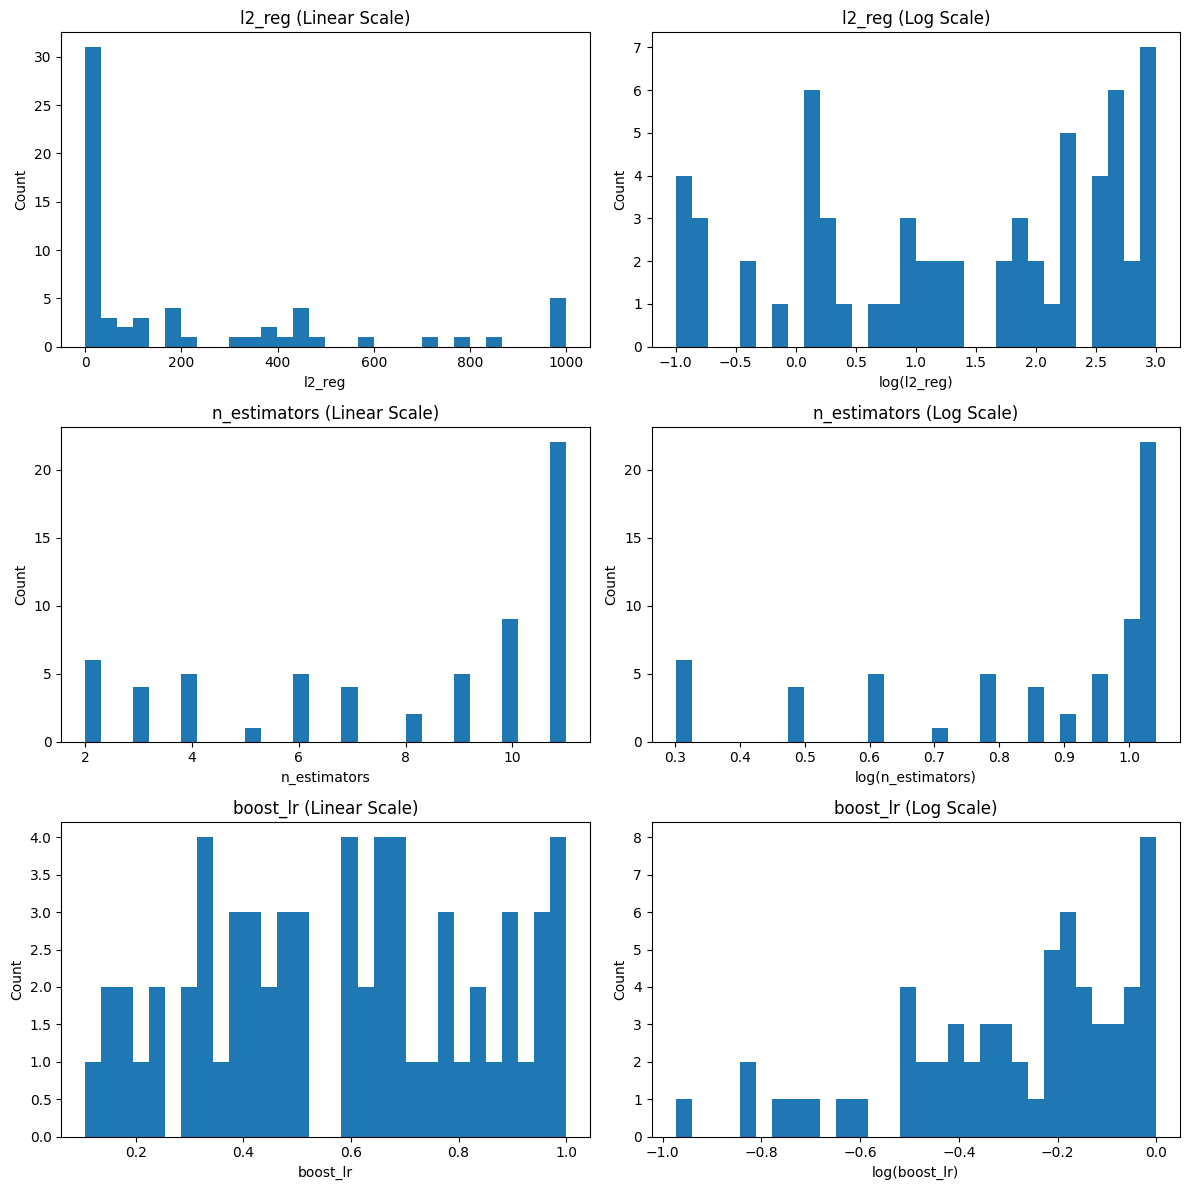

In [10]:

# Example usage:
fig = plot_distribution(
    parameters = [ "l2_reg", "n_estimators", "boost_lr"],
    model_name = "HydraLabelBoost_OH",
    results_dir = Config.project_dir / "results",
)
plt.show()

# Get training times

In [11]:
def get_regressor_fit_and_estimate_time(
    model_name: str,
    datasets: List[str],
    results_dir: Path,
    benchmarks: Dict,
    ):
    results = {}
    for dataset_name in datasets:
        rr = load_regressor_results(
            results_dir / model_name / "Predictions" / dataset_name / f"testResample{0}.csv"
        )
        results[dataset_name] = rr.fit_time #TODO fit only atm
    benchmarks[model_name] = results
    return results



def get_model_fit_times(
    datasets: List[str] = TSER_datasets,
    # project_dir: Path = Config.project_dir,
    results_dir: Path = Config.results_dir,
    new_models: List[str] = ["NaiveMean"],
    # aeon_models: List[str] = ["InceptionT", "FreshPRINCE", "DrCIF", "Rocket", "RandF", "RotF", "XGBoost", "Ridge"],
    benchmarks: Optional[Dict] = None
):
    # get aeon benchmarks
    if benchmarks is None:
        benchmarks = {}
    
    # add my own models
    for model_name in new_models:
        get_regressor_fit_and_estimate_time(
            model_name,
            datasets,
            results_dir,
            benchmarks
        )
    return benchmarks

time_bench = get_model_fit_times(
    TSER_datasets[:],
    results_dir = Config.project_dir / "results",
    new_models = ["NaiveMean", "HydraFeatureBoost_OH", "HydraLabelBoost_OH", "HydraLabelReuseBoost_OH", "Hydra_OH"], #"HydraFeatureBoost", "HydraLabelBoost"]
)

/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/rds/general/user/nz423/home/miniforge3/envs/hydraboost/lib/python3.11/site-packages/

In [12]:
time_table = pd.DataFrame(time_bench) / 3.6e6 # Convert from milliseconds to hours
time_table

,NaiveMean,HydraFeatureBoost_OH,HydraLabelBoost_OH,HydraLabelReuseBoost_OH,Hydra_OH
BIDMC32HR,0.000036,1.066684,1.713638,0.130420,0.215286
BIDMC32SpO2,0.000032,0.946285,1.713051,0.130675,0.214945
PPGDalia,0.000036,0.348139,0.498363,0.037978,0.057835
BIDMC32RR,0.000032,1.093478,1.622452,0.128849,0.211864
NewsTitleSentiment,0.000020,0.162615,0.088614,0.029187,0.037894
...,...,...,...,...,...
BitcoinSentiment,0.000003,0.004070,0.002069,0.000878,0.000324
BinanceCoinSentiment,0.000001,0.003170,0.002206,0.001098,0.000326
DailyOilGasPrices,0.000002,0.004380,0.002557,0.000620,0.000324
CardanoSentiment,0.000006,0.003160,0.001123,0.000695,0.000325


In [13]:
time_table.sum()

NaiveMean                  0.000509
HydraFeatureBoost_OH       7.152035
HydraLabelBoost_OH         8.553490
HydraLabelReuseBoost_OH    0.903744
Hydra_OH                   1.192572
dtype: float64

# TODO



Features:
* For now only do wide not deep representation boosting
* percentage of dataset to be used at each boosting iteration
* What solver to use for least squares? do i need batching here for the big datasets?
* How to initialize Phi_0? Should i use different n_features for the initial guess? Use all data for initial? TSFresh or hydra features? Or do i do some sort of flattened PCA?
* plot l2 vs N


Would be interesting to see difference between boosting in label space vs representation boosting



# Implement:

* why is the majority of the time spent on sampling uniform random variables? is this from 10000 x 10000 ridge matrix initialization?